# Seafood Supply Chain Analysis

This notebook analyzes seafood supply chain data with a focus on:
- Time series analysis and forecasting
- Regression models for pricing and demand prediction
- Economic Order Quantity (EOQ) calculations
- Impact analysis of the 2010 volcanic eruption on seafood exports

All data is syntetic and generated for the purpose of visualizing potentioal toos and methods used in supply chain analysis.

## Import Required Libraries

In [ ]:
# Import fundamental data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import time series analysis libraries
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
sns.set_context("notebook", font_scale=1.2)

# Configure plot display
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

## Data generation


In [ ]:
# Sample code to load data 
# For demonstration purposes, we'll create synthetic data

# Time series data (monthly exports from 2000-2023)
dates = pd.date_range(start='2000-01-01', end='2023-12-31', freq='M')
np.random.seed(42)

# Create export data with seasonal pattern and trend
trend = np.linspace(0, 15, len(dates))
seasonal = 5 * np.sin(np.arange(len(dates)) * (2 * np.pi / 12))
noise = np.random.normal(0, 1, len(dates))

# Add effect of 2010 volcanic eruption (April 2010)
eruption_effect = np.zeros(len(dates))
eruption_start = np.where(dates >= '2010-04-01')[0][0]
eruption_effect[eruption_start:eruption_start+12] = -8 * np.exp(-np.arange(12) / 6)

# Create export data for different fish types
export_data = pd.DataFrame({
    'Date': dates,
    'Cod': 100 + trend + seasonal + noise * 2 + eruption_effect,
    'Salmon': 150 + trend * 1.5 + seasonal * 1.2 + np.random.normal(0, 1.5, len(dates)) + eruption_effect * 0.8,
    'Tuna': 120 + trend * 0.8 + seasonal * 1.5 + np.random.normal(0, 1.2, len(dates)) + eruption_effect * 1.2,
    'Mackerel': 80 + trend * 0.6 + seasonal * 0.8 + np.random.normal(0, 1, len(dates)) + eruption_effect * 0.5
})

# Set date as index
export_data.set_index('Date', inplace=True)

# Create price and demand data for regression analysis
price_demand_data = pd.DataFrame({
    'Date': dates,
    'Cod_Price': 15 + trend * 0.2 + seasonal * 0.1 + np.random.normal(0, 0.5, len(dates)),
    'Cod_Demand': 100 + trend + seasonal + np.random.normal(0, 5, len(dates)),
    'Salmon_Price': 20 + trend * 0.3 + seasonal * 0.15 + np.random.normal(0, 0.7, len(dates)),
    'Salmon_Demand': 150 + trend * 1.5 + seasonal * 1.2 + np.random.normal(0, 8, len(dates))
})

# Display the first few rows of each dataset
print("Export Data:")
display(export_data.head())

print("\nPrice and Demand Data:")
display(price_demand_data.head())

Export Data:


C:\Users\Isak\AppData\Local\Temp\ipykernel_21472\2482908958.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2000-01-01', end='2023-12-31', freq='M')


,Cod,Salmon,Tuna,Mackerel
Date,,,,
2000-01-31,100.993428,150.421488,120.282737,79.387211
2000-02-29,102.275736,152.144348,124.716850,81.643657
2000-03-31,105.730034,155.040763,124.804511,83.812685
2000-04-30,108.202854,155.495690,128.997940,84.428533
2000-05-31,104.070880,154.625694,127.068634,84.248081



Price and Demand Data:


,Date,Cod_Price,Cod_Demand,Salmon_Price,Salmon_Demand
0,2000-01-31,14.680519,103.314406,20.257101,147.883881
1,2000-02-29,14.598908,108.419634,21.677408,137.047498
2,2000-03-31,16.274926,105.339764,20.524452,160.436291
3,2000-04-30,16.036267,98.672635,20.552517,146.321124
4,2000-05-31,15.130749,106.537626,20.698643,155.989202


## Data Filtering and Preparation

Filter and prepare export data from 2000 to 2023, focusing on relevant fish types.

Missing values in export data:
Cod         0
Salmon      0
Tuna        0
Mackerel    0
dtype: int64

Missing values in price and demand data:
Date             0
Cod_Price        0
Cod_Demand       0
Salmon_Price     0
Salmon_Demand    0
dtype: int64

Summary statistics for export data:


,Cod,Salmon,Tuna,Mackerel
count,288.000000,288.000000,288.000000,288.000000
mean,107.321356,161.087712,125.862507,84.570830
std,5.969450,7.695623,6.500360,4.009322
min,94.609317,145.166524,112.203532,75.407450
25%,103.107728,155.025296,121.257576,81.626641
50%,107.418456,161.031293,126.129731,84.806052
75%,111.487597,166.912583,130.709248,87.312531
max,121.497389,178.153642,139.823489,93.481994


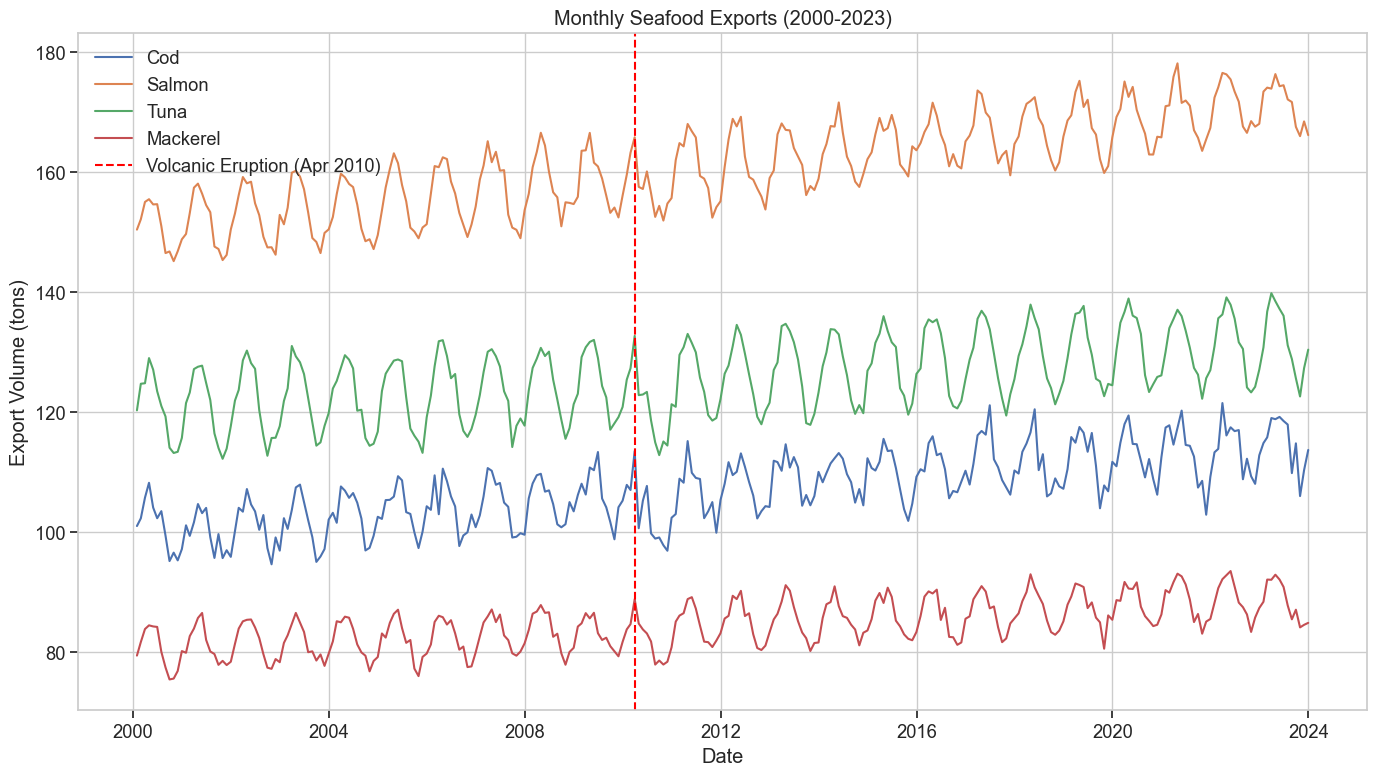

In [ ]:
# Check for missing values
print("Missing values in export data:")
print(export_data.isnull().sum())

print("\nMissing values in price and demand data:")
print(price_demand_data.isnull().sum())

# Basic statistics of export data
print("\nSummary statistics for export data:")
display(export_data.describe())

# Prepare time-based features
export_data['Month'] = export_data.index.month
export_data['Year'] = export_data.index.year
export_data['Quarter'] = export_data.index.quarter

# Create a binary feature for pre/post eruption
eruption_date = pd.Timestamp('2010-04-01')
export_data['Post_Eruption'] = (export_data.index >= eruption_date).astype(int)

# Plot monthly exports for each fish type
plt.figure(figsize=(14, 8))
for column in ['Cod', 'Salmon', 'Tuna', 'Mackerel']:
    plt.plot(export_data.index, export_data[column], label=column)

plt.axvline(x=eruption_date, color='r', linestyle='--', label='Volcanic Eruption (Apr 2010)')
plt.title('Monthly Seafood Exports (2000-2023)')
plt.xlabel('Date')
plt.ylabel('Export Volume (tons)')
plt.legend()
plt.tight_layout()
plt.show()

## Cumulative Analysis

Perform cumulative sum analysis on time series data to observe trends over time.

In [1]:
# Calculate cumulative exports
cumulative_exports = export_data[['Cod', 'Salmon', 'Tuna', 'Mackerel']].cumsum()

# Calculate growth rates
yearly_growth = yearly_exports.pct_change() * 100

# Plot yearly growth rates
plt.figure(figsize=(14, 8))
for column in ['Cod', 'Salmon', 'Tuna', 'Mackerel']:
    plt.plot(yearly_growth.index[1:], yearly_growth[column][1:], label=column, marker='o')

plt.axvline(x=2010, color='r', linestyle='--', label='Volcanic Eruption (2010)')
plt.title('Yearly Growth Rate in Seafood Exports (%)')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

NameError: name 'export_data' is not defined

## Export Trends Before and After Eruption

Plot export trends before and after the 2010 volcanic eruption, highlighting any significant changes.

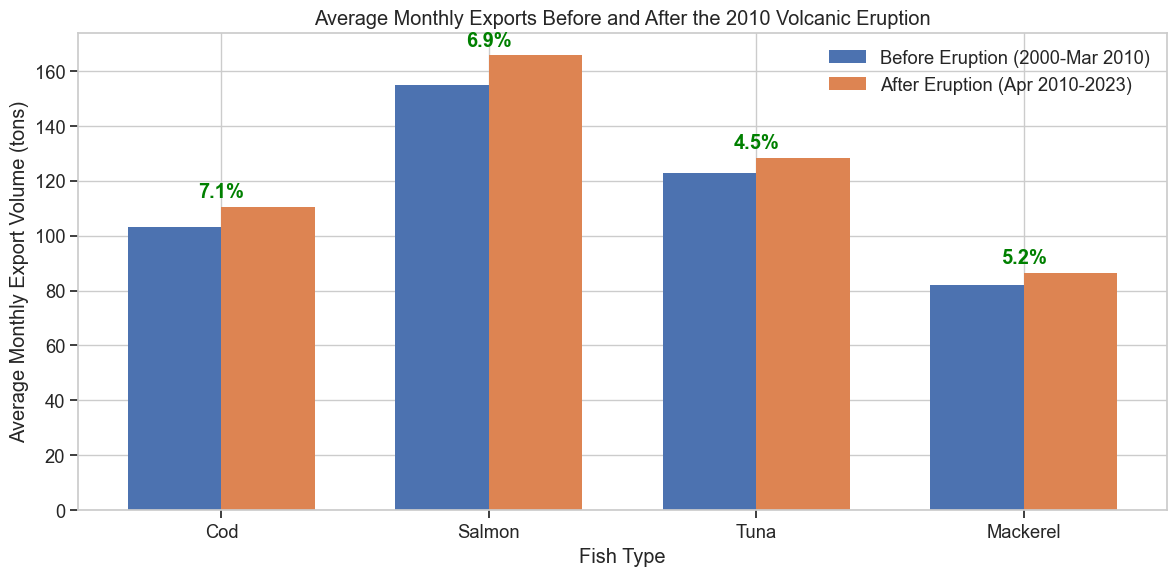

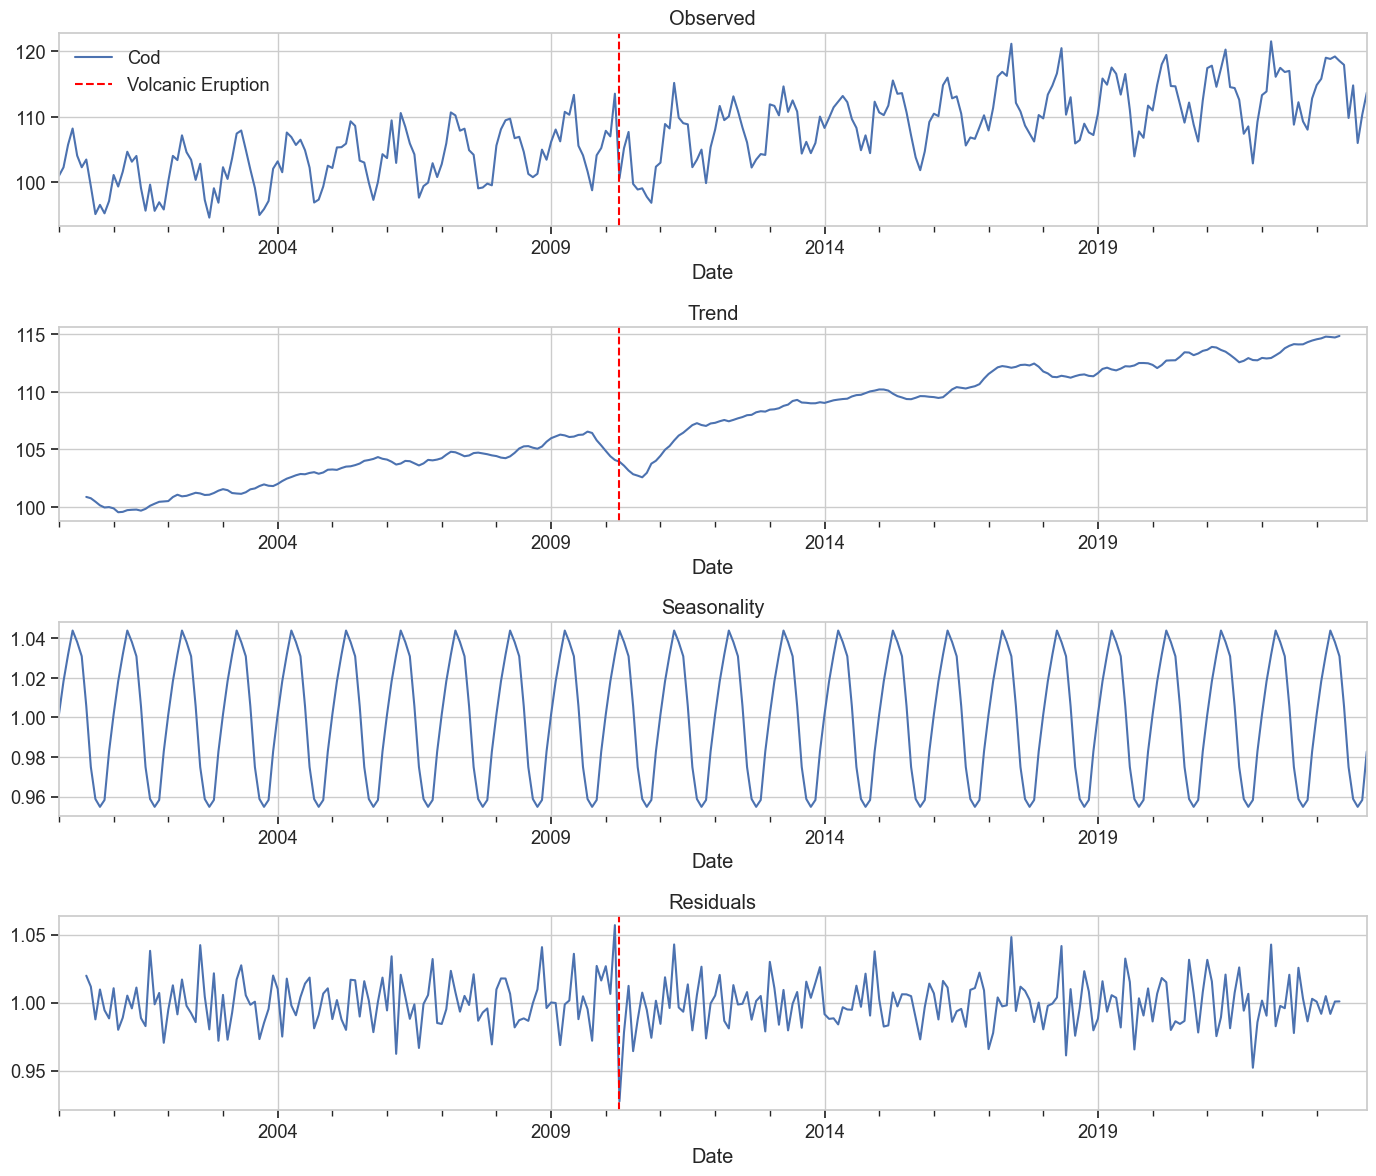

In [ ]:
# Separate data into before and after eruption
before_eruption = export_data[export_data.index < eruption_date]
after_eruption = export_data[export_data.index >= eruption_date]

# Calculate average monthly exports before and after eruption
before_avg = before_eruption[['Cod', 'Salmon', 'Tuna', 'Mackerel']].mean()
after_avg = after_eruption[['Cod', 'Salmon', 'Tuna', 'Mackerel']].mean()
percent_change = ((after_avg - before_avg) / before_avg) * 100

# Create a bar chart comparing average monthly exports
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(before_avg))

plt.bar(x - bar_width/2, before_avg, bar_width, label='Before Eruption (2000-Mar 2010)')
plt.bar(x + bar_width/2, after_avg, bar_width, label='After Eruption (Apr 2010-2023)')

plt.xlabel('Fish Type')
plt.ylabel('Average Monthly Export Volume (tons)')
plt.title('Average Monthly Exports Before and After the 2010 Volcanic Eruption')
plt.xticks(x, before_avg.index)
plt.legend()

# Add percentage change labels
for i, (b, a, p) in enumerate(zip(before_avg, after_avg, percent_change)):
    plt.annotate(f'{p:.1f}%', 
                 xy=(i, max(b, a) + 2),
                 ha='center', 
                 va='bottom',
                 fontweight='bold',
                 color='green' if p > 0 else 'red')

plt.tight_layout()
plt.show()

# Time series decomposition for a specific fish type (e.g., Cod)
cod_ts = export_data['Cod']
decomposition = seasonal_decompose(cod_ts, model='multiplicative', period=12)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.axvline(x=eruption_date, color='r', linestyle='--', label='Volcanic Eruption')
ax1.legend()

decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.axvline(x=eruption_date, color='r', linestyle='--')

decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')

decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals')
ax4.axvline(x=eruption_date, color='r', linestyle='--')

plt.tight_layout()
plt.show()

## Comparison of Common Fish Types

Analyze and compare export trends for common fish types, adding a line to show average changes for context.

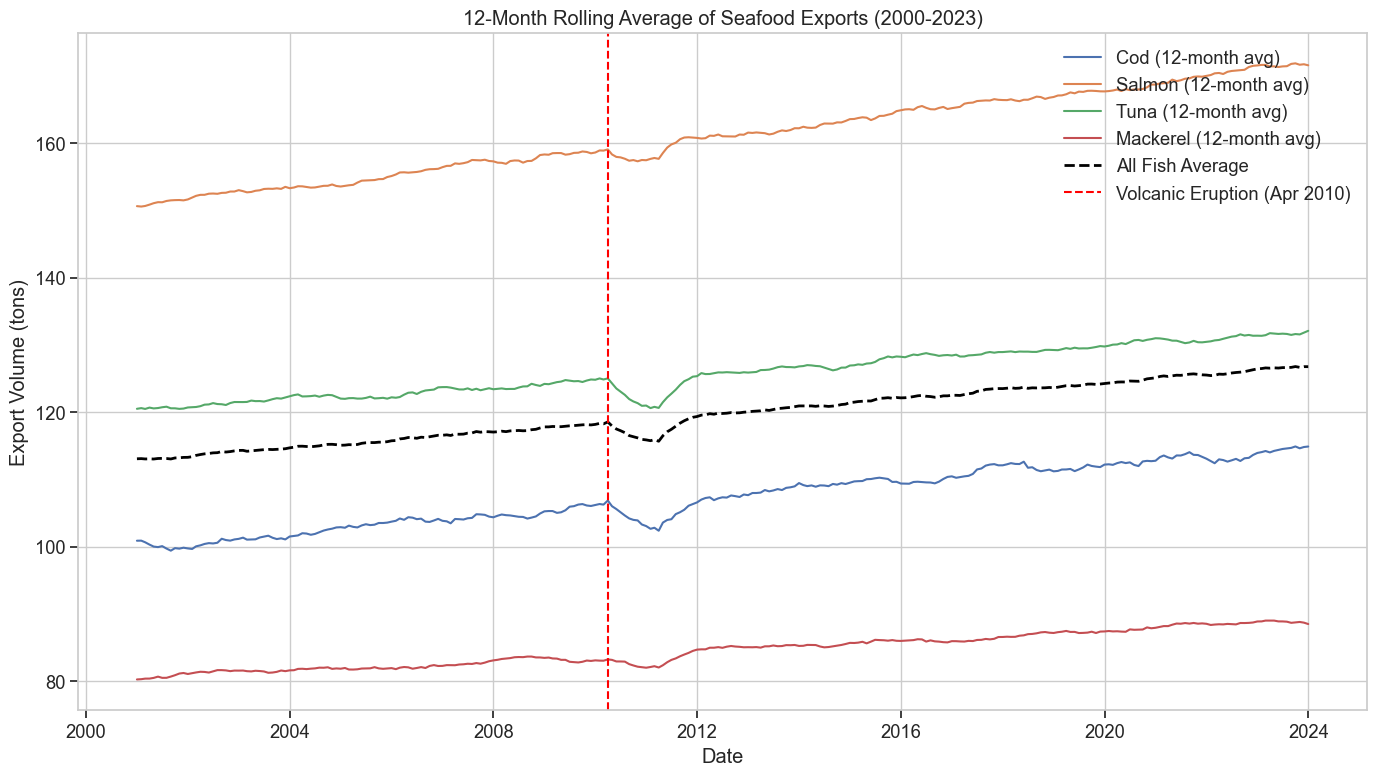

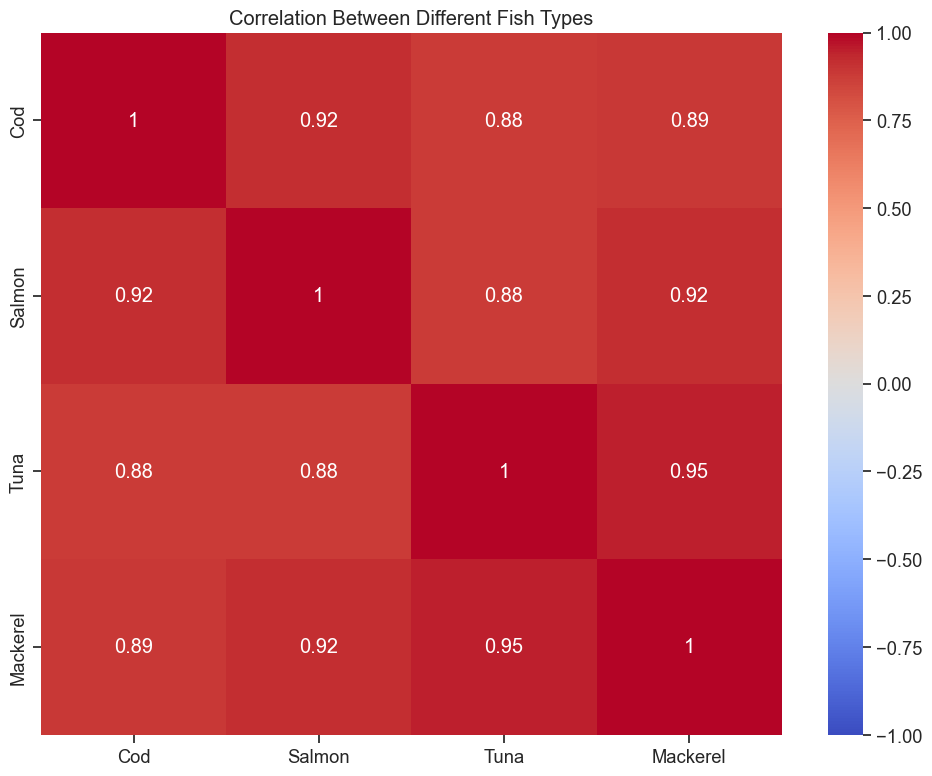

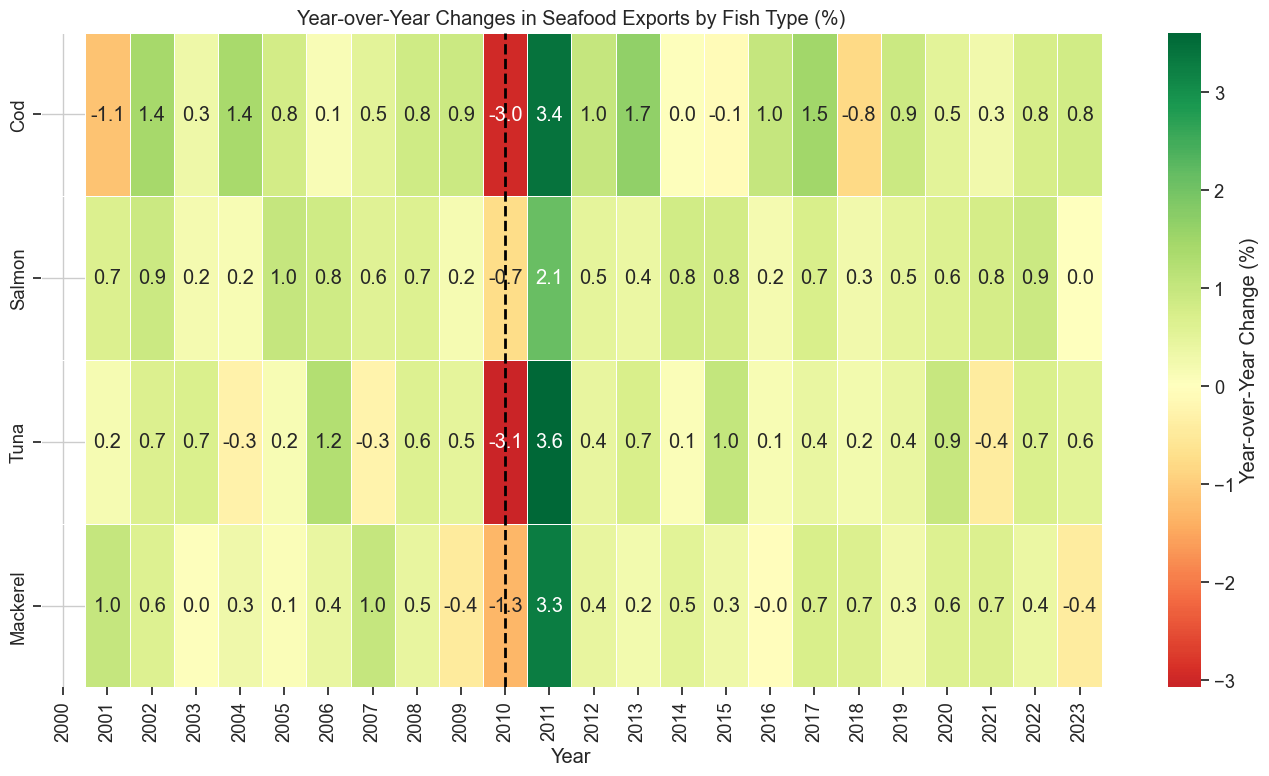

In [ ]:
# Calculate 12-month rolling average for each fish type
rolling_avg = export_data[['Cod', 'Salmon', 'Tuna', 'Mackerel']].rolling(window=12).mean()

# Plot the 12-month rolling average with the eruption marked
plt.figure(figsize=(14, 8))
for column in ['Cod', 'Salmon', 'Tuna', 'Mackerel']:
    plt.plot(rolling_avg.index, rolling_avg[column], label=f'{column} (12-month avg)')

# Add a line for average of all fish types
all_fish_avg = rolling_avg.mean(axis=1)
plt.plot(rolling_avg.index, all_fish_avg, label='All Fish Average', 
         color='black', linewidth=2, linestyle='--')

plt.axvline(x=eruption_date, color='r', linestyle='--', label='Volcanic Eruption (Apr 2010)')
plt.title('12-Month Rolling Average of Seafood Exports (2000-2023)')
plt.xlabel('Date')
plt.ylabel('Export Volume (tons)')
plt.legend()
plt.tight_layout()
plt.show()

# Create a heatmap of correlation between fish types
correlation = export_data[['Cod', 'Salmon', 'Tuna', 'Mackerel']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Between Different Fish Types')
plt.tight_layout()
plt.show()

# Analyze year-over-year changes by fish type
yearly_data = export_data.groupby('Year')[['Cod', 'Salmon', 'Tuna', 'Mackerel']].sum()
yearly_change = yearly_data.pct_change() * 100

# Create a heatmap of yearly changes
plt.figure(figsize=(14, 8))
sns.heatmap(yearly_change.T, annot=True, cmap='RdYlGn', center=0, fmt='.1f',
            linewidths=.5, cbar_kws={'label': 'Year-over-Year Change (%)'})
plt.title('Year-over-Year Changes in Seafood Exports by Fish Type (%)')
plt.axvline(x=yearly_change.index.get_loc(2010)+0.5, color='black', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()

## Naïve Forecasting

Implement a naïve forecasting model where the last observed value is used as the forecast.

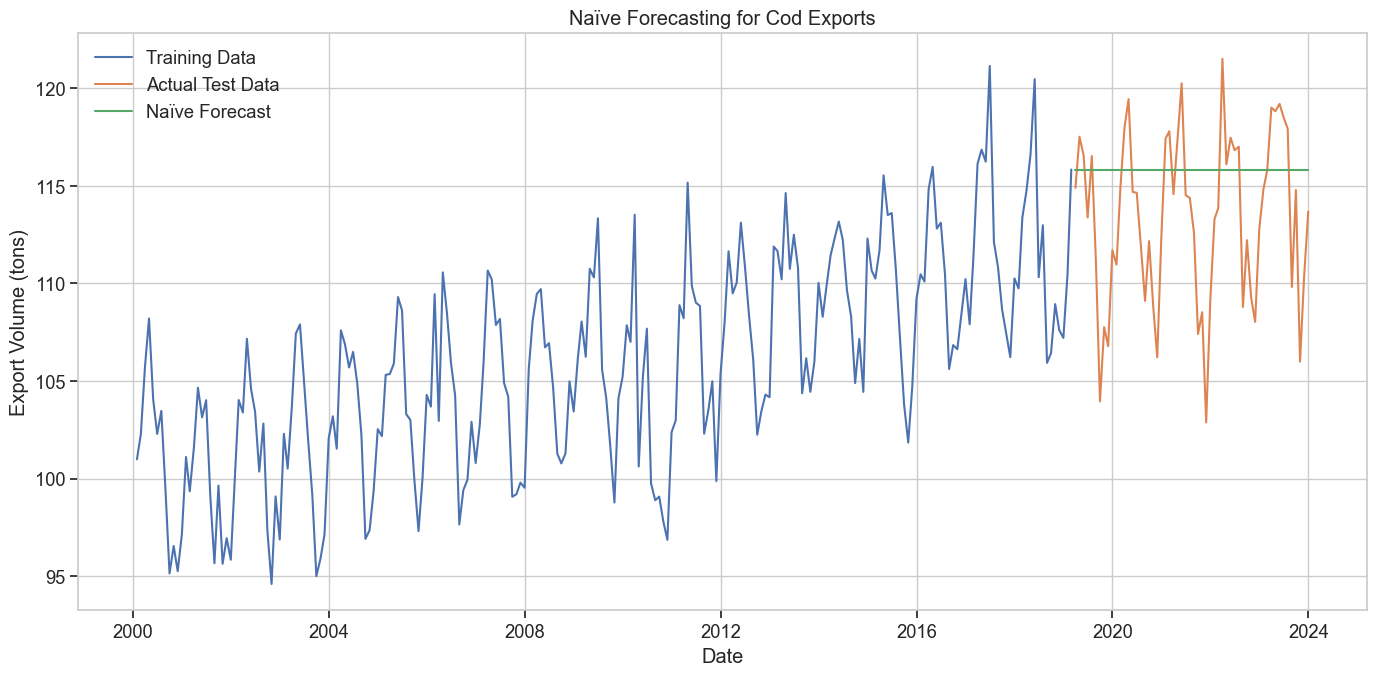

Naïve Forecast Performance:
MAE: 3.9110
RMSE: 4.9570
MAPE: 3.5404


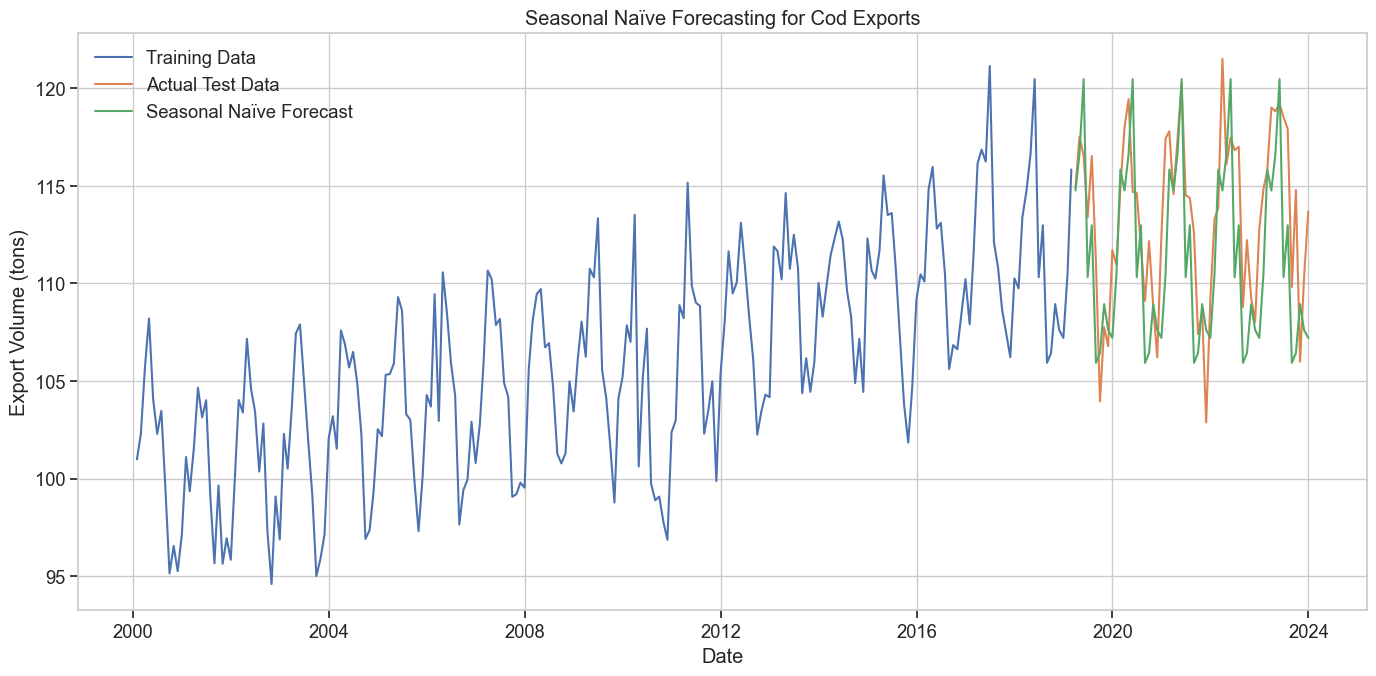


Seasonal Naïve Forecast Performance:
MAE: 3.1119
RMSE: 3.8440
MAPE: 2.7323


In [ ]:
# Function to evaluate forecast accuracy
def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Let's use Cod data for demonstrating forecasting methods
cod_data = export_data['Cod'].copy()

# Split data into training and testing
train_size = int(len(cod_data) * 0.8)
train, test = cod_data[:train_size], cod_data[train_size:]

# Naïve forecast: last observed value in training set
naive_forecast = np.full(len(test), train.iloc[-1])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, naive_forecast, label='Naïve Forecast')
plt.title('Naïve Forecasting for Cod Exports')
plt.xlabel('Date')
plt.ylabel('Export Volume (tons)')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the naïve forecast
naive_metrics = evaluate_forecast(test, naive_forecast)
print("Naïve Forecast Performance:")
for metric, value in naive_metrics.items():
    print(f"{metric}: {value:.4f}")

# Naïve seasonal forecast: use value from same month in previous year
seasonal_naive_forecast = []
for i in range(len(test)):
    # Get the index in the training data that corresponds to the same month in the previous year
    index_in_train = train_size - 12 + i % 12
    while index_in_train >= train_size:
        index_in_train -= 12
    seasonal_naive_forecast.append(train.iloc[index_in_train])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, seasonal_naive_forecast, label='Seasonal Naïve Forecast')
plt.title('Seasonal Naïve Forecasting for Cod Exports')
plt.xlabel('Date')
plt.ylabel('Export Volume (tons)')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the seasonal naïve forecast
seasonal_naive_metrics = evaluate_forecast(test, seasonal_naive_forecast)
print("\nSeasonal Naïve Forecast Performance:")
for metric, value in seasonal_naive_metrics.items():
    print(f"{metric}: {value:.4f}")

## Moving Average

Apply moving average techniques to smooth the time series data and identify trends.

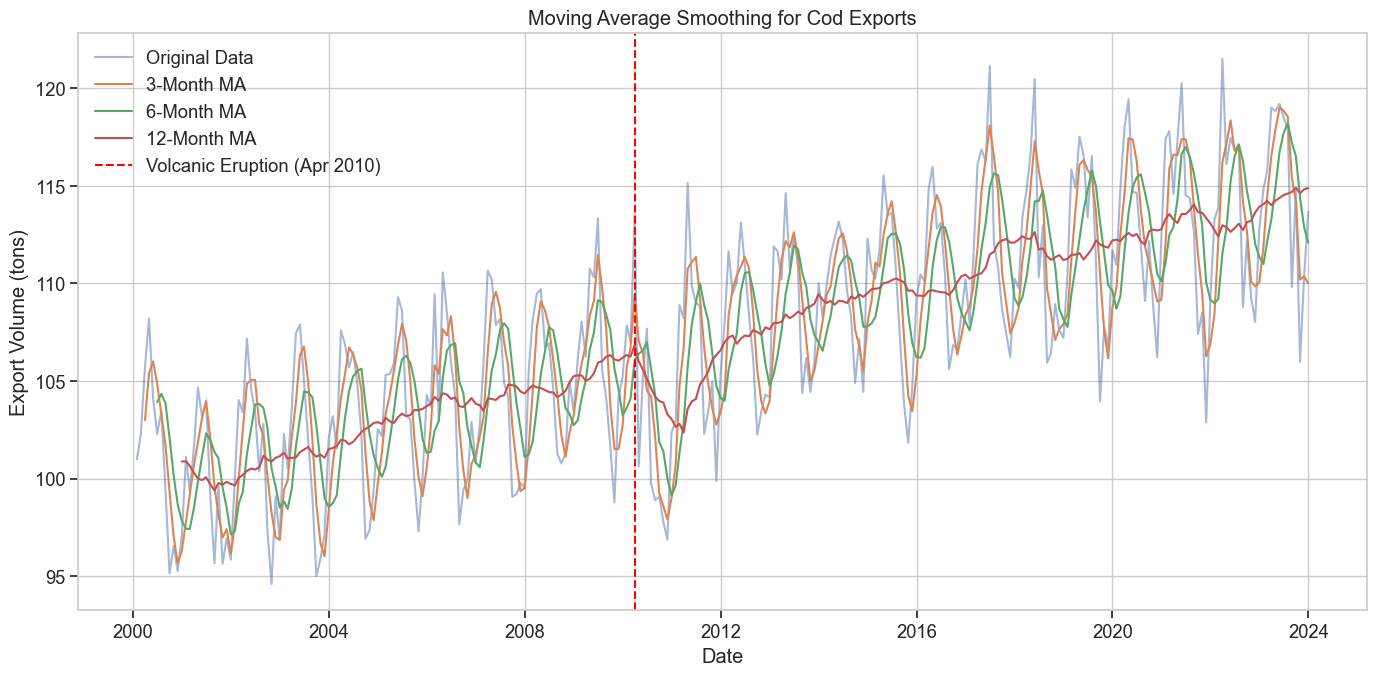

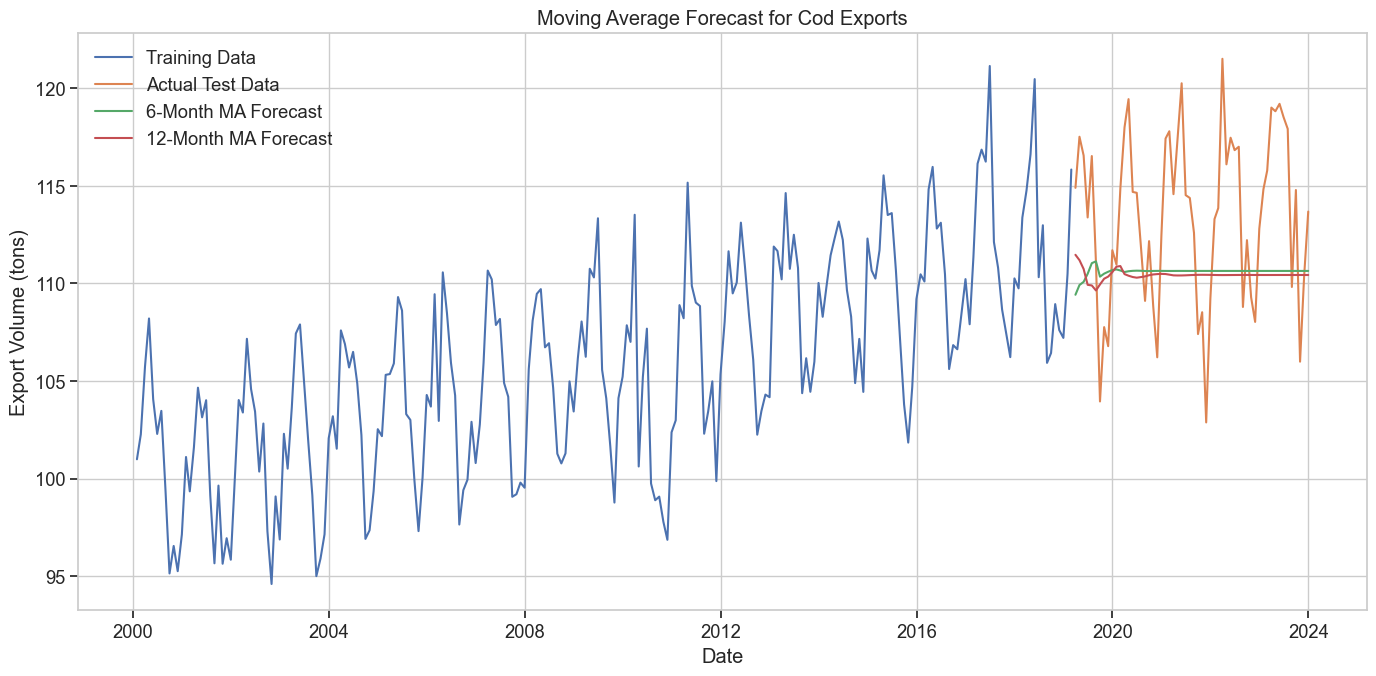

6-Month Moving Average Forecast Performance:
MAE: 4.3954
RMSE: 5.1422
MAPE: 3.8282

12-Month Moving Average Forecast Performance:
MAE: 4.4363
RMSE: 5.1893
MAPE: 3.8603


In [ ]:
# Calculate different moving averages
ma_3 = cod_data.rolling(window=3).mean()
ma_6 = cod_data.rolling(window=6).mean()
ma_12 = cod_data.rolling(window=12).mean()

# Plot the different moving averages
plt.figure(figsize=(14, 7))
plt.plot(cod_data.index, cod_data, label='Original Data', alpha=0.5)
plt.plot(ma_3.index, ma_3, label='3-Month MA')
plt.plot(ma_6.index, ma_6, label='6-Month MA')
plt.plot(ma_12.index, ma_12, label='12-Month MA')
plt.axvline(x=eruption_date, color='r', linestyle='--', label='Volcanic Eruption (Apr 2010)')
plt.title('Moving Average Smoothing for Cod Exports')
plt.xlabel('Date')
plt.ylabel('Export Volume (tons)')
plt.legend()
plt.tight_layout()
plt.show()

# Moving Average Forecast
def moving_avg_forecast(series, window, horizon):
    forecast = []
    for i in range(horizon):
        if i == 0:
            # For the first forecast, use the last 'window' values from training
            value = series[-window:].mean()
        else:
            # For subsequent forecasts, include previous forecasts in the window
            remaining_actual = window - i
            if remaining_actual > 0:
                value = (series[-remaining_actual:].sum() + sum(forecast)) / window
            else:
                value = sum(forecast[-window:]) / window
        forecast.append(value)
    return forecast

# Generate MA forecast
ma_forecast_6 = moving_avg_forecast(train, 6, len(test))
ma_forecast_12 = moving_avg_forecast(train, 12, len(test))

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, ma_forecast_6, label='6-Month MA Forecast')
plt.plot(test.index, ma_forecast_12, label='12-Month MA Forecast')
plt.title('Moving Average Forecast for Cod Exports')
plt.xlabel('Date')
plt.ylabel('Export Volume (tons)')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the MA forecasts
ma_6_metrics = evaluate_forecast(test, ma_forecast_6)
ma_12_metrics = evaluate_forecast(test, ma_forecast_12)

print("6-Month Moving Average Forecast Performance:")
for metric, value in ma_6_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\n12-Month Moving Average Forecast Performance:")
for metric, value in ma_12_metrics.items():
    print(f"{metric}: {value:.4f}")

## Exponential Smoothing

Use exponential smoothing to forecast future values in the time series.

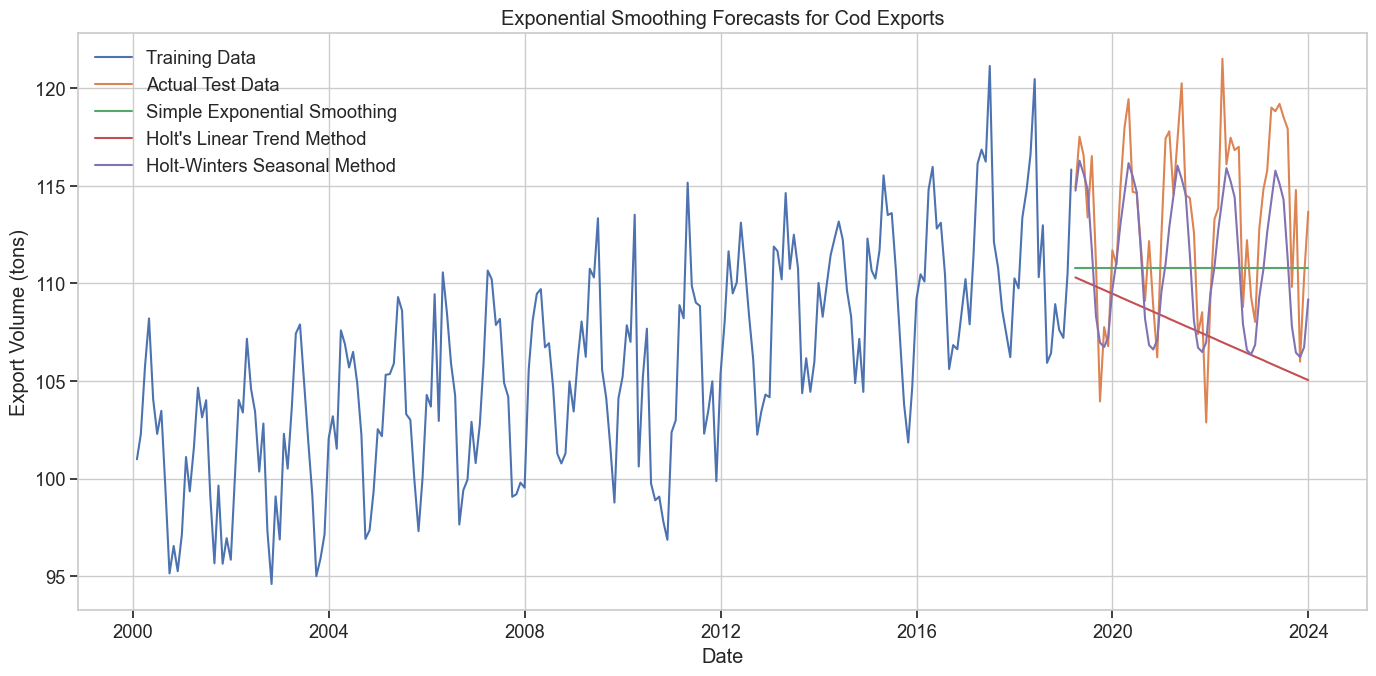

Simple Exponential Smoothing Performance:
MAE: 4.2963
RMSE: 5.0179
MAPE: 3.7463

Holt's Linear Trend Method Performance:
MAE: 6.2993
RMSE: 7.3915
MAPE: 5.4548

Holt-Winters Seasonal Method Performance:
MAE: 2.6865
RMSE: 3.3718
MAPE: 2.3459


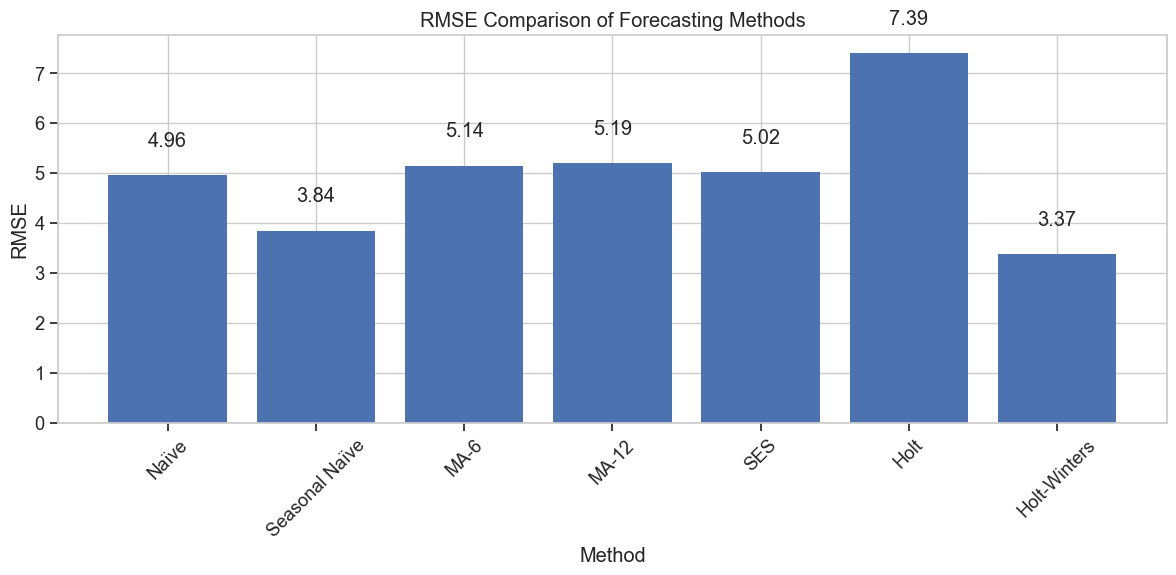

In [ ]:
# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.2)
ses_forecast = ses_model.forecast(len(test))

# Holt's Linear Trend Method
holt_model = Holt(train).fit(smoothing_level=0.2, smoothing_trend=0.1)
holt_forecast = holt_model.forecast(len(test))

# Holt-Winters Seasonal Method (additive)
hw_model = ExponentialSmoothing(
    train, 
    seasonal_periods=12, 
    trend='add', 
    seasonal='add'
).fit(smoothing_level=0.2, smoothing_trend=0.1, smoothing_seasonal=0.1)
hw_forecast = hw_model.forecast(len(test))

# Plot the forecasts
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, ses_forecast, label='Simple Exponential Smoothing')
plt.plot(test.index, holt_forecast, label="Holt's Linear Trend Method")
plt.plot(test.index, hw_forecast, label='Holt-Winters Seasonal Method')
plt.title('Exponential Smoothing Forecasts for Cod Exports')
plt.xlabel('Date')
plt.ylabel('Export Volume (tons)')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the exponential smoothing forecasts
ses_metrics = evaluate_forecast(test, ses_forecast)
holt_metrics = evaluate_forecast(test, holt_forecast)
hw_metrics = evaluate_forecast(test, hw_forecast)

print("Simple Exponential Smoothing Performance:")
for metric, value in ses_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nHolt's Linear Trend Method Performance:")
for metric, value in holt_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nHolt-Winters Seasonal Method Performance:")
for metric, value in hw_metrics.items():
    print(f"{metric}: {value:.4f}")

# Create a bar chart comparing all forecasting methods
methods = ['Naïve', 'Seasonal Naïve', 'MA-6', 'MA-12', 'SES', 'Holt', 'Holt-Winters']
rmse_values = [
    naive_metrics['RMSE'],
    seasonal_naive_metrics['RMSE'],
    ma_6_metrics['RMSE'],
    ma_12_metrics['RMSE'],
    ses_metrics['RMSE'],
    holt_metrics['RMSE'],
    hw_metrics['RMSE']
]

plt.figure(figsize=(12, 6))
bars = plt.bar(methods, rmse_values)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.2f}', ha='center', va='bottom')

plt.title('RMSE Comparison of Forecasting Methods')
plt.xlabel('Method')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Define Cost Parameters

Set up cost parameters such as ordering costs and carrying costs, either using constants or assumptions.

In [ ]:
# Define cost parameters for inventory management
cost_parameters = {
    'Cod': {
        'ordering_cost': 500,       # Cost per order in $
        'carrying_cost_percent': 0.25,  # Annual carrying cost as a percentage of unit cost
        'unit_cost': 15,           # Cost per unit in $
        'lead_time_days': 10,      # Lead time in days
        'service_level': 0.95      # Service level (95%)
    },
    'Salmon': {
        'ordering_cost': 600,
        'carrying_cost_percent': 0.28,
        'unit_cost': 20,
        'lead_time_days': 8,
        'service_level': 0.95
    },
    'Tuna': {
        'ordering_cost': 550,
        'carrying_cost_percent': 0.26,
        'unit_cost': 18,
        'lead_time_days': 12,
        'service_level': 0.95
    },
    'Mackerel': {
        'ordering_cost': 450,
        'carrying_cost_percent': 0.22,
        'unit_cost': 12,
        'lead_time_days': 7,
        'service_level': 0.95
    }
}

# Calculate carrying cost per unit for each fish type
for fish, params in cost_parameters.items():
    params['carrying_cost'] = params['unit_cost'] * params['carrying_cost_percent']
    
# Display the cost parameters
cost_df = pd.DataFrame(cost_parameters).T
display(cost_df)

# Calculate average monthly demand for each fish type
monthly_demand = export_data.resample('M').mean()
avg_monthly_demand = monthly_demand.mean()

print("\nAverage Monthly Demand:")
display(avg_monthly_demand)

,ordering_cost,carrying_cost_percent,unit_cost,lead_time_days,service_level,carrying_cost
Cod,500.0,0.25,15.0,10.0,0.95,3.75
Salmon,600.0,0.28,20.0,8.0,0.95,5.60
Tuna,550.0,0.26,18.0,12.0,0.95,4.68
Mackerel,450.0,0.22,12.0,7.0,0.95,2.64



Average Monthly Demand:


Cod               107.321356
Salmon            161.087712
Tuna              125.862507
Mackerel           84.570830
Month               6.500000
Year             2011.500000
Quarter             2.500000
Post_Eruption       0.572917
dtype: float64

## EOQ Calculation

Calculate the Economic Order Quantity (EOQ) based on the defined cost parameters and demand data.

,Annual Demand,EOQ,Safety Stock,Reorder Point,Annual Orders,Order Frequency (days),Annual Ordering Cost,Annual Carrying Cost,Total Annual Inventory Cost
Cod,1287.86,586.03,3.68,38.97,2.20,166.09,1098.80,1112.61,2211.41
Salmon,1933.05,643.60,4.94,47.31,3.00,121.53,1802.09,1829.77,3631.86
Tuna,1510.35,595.82,4.73,54.39,2.53,143.99,1394.21,1416.35,2810.56
Mackerel,1014.85,588.19,2.43,21.89,1.73,211.55,776.42,782.82,1559.24


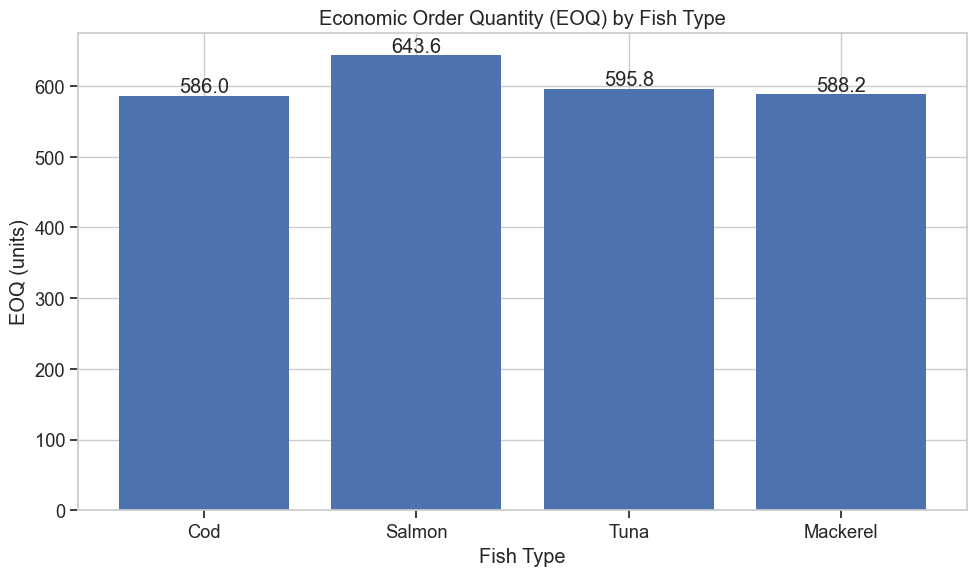

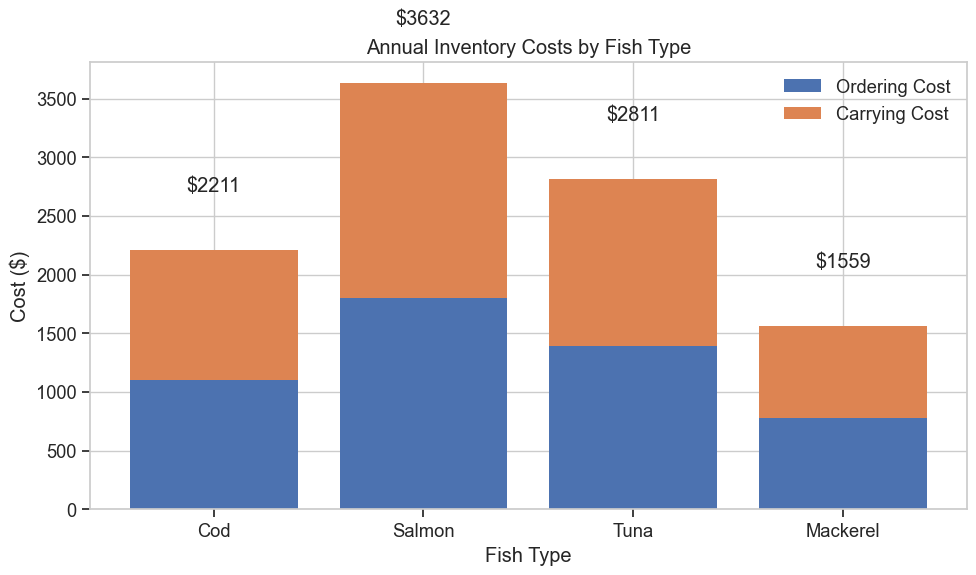

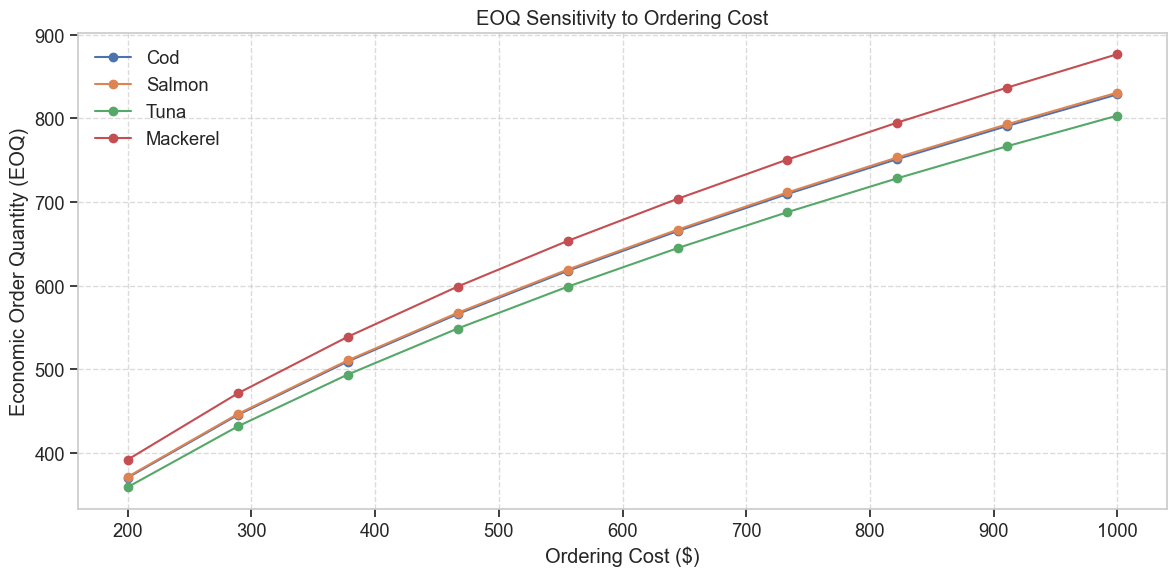

In [ ]:
# Function to calculate EOQ
def calculate_eoq(annual_demand, ordering_cost, carrying_cost):
    return np.sqrt((2 * annual_demand * ordering_cost) / carrying_cost)

# Function to calculate reorder point
def calculate_reorder_point(avg_daily_demand, lead_time, safety_stock):
    return (avg_daily_demand * lead_time) + safety_stock

# Function to calculate safety stock
def calculate_safety_stock(service_level, lead_time, std_daily_demand):
    # Z-score for the service level
    z_scores = {
        0.90: 1.28,
        0.95: 1.65,
        0.98: 2.05,
        0.99: 2.33
    }
    z = z_scores.get(service_level, 1.65)  # Default to 95% if service level not found
    
    return z * std_daily_demand * np.sqrt(lead_time)

# Calculate EOQ and related metrics for each fish type
inventory_results = {}

for fish in ['Cod', 'Salmon', 'Tuna', 'Mackerel']:
    # Get parameters
    params = cost_parameters[fish]
    ordering_cost = params['ordering_cost']
    carrying_cost = params['carrying_cost']
    lead_time = params['lead_time_days']
    service_level = params['service_level']
    
    # Calculate annual demand (monthly * 12)
    annual_demand = avg_monthly_demand[fish] * 12
    
    # Calculate daily demand and its standard deviation
    daily_demand = annual_demand / 365
    
    # Calculate standard deviation of daily demand (assumed to be 20% of daily demand)
    std_daily_demand = daily_demand * 0.2
    
    # Calculate EOQ
    eoq = calculate_eoq(annual_demand, ordering_cost, carrying_cost)
    
    # Calculate safety stock
    safety_stock = calculate_safety_stock(service_level, lead_time, std_daily_demand)
    
    # Calculate reorder point
    reorder_point = calculate_reorder_point(daily_demand, lead_time, safety_stock)
    
    # Calculate annual ordering cost
    annual_orders = annual_demand / eoq
    annual_ordering_cost = annual_orders * ordering_cost
    
    # Calculate annual carrying cost
    average_inventory = eoq / 2 + safety_stock
    annual_carrying_cost = average_inventory * carrying_cost
    
    # Calculate total annual inventory cost
    total_annual_cost = annual_ordering_cost + annual_carrying_cost
    
    # Store results
    inventory_results[fish] = {
        'Annual Demand': annual_demand,
        'EOQ': eoq,
        'Safety Stock': safety_stock,
        'Reorder Point': reorder_point,
        'Annual Orders': annual_orders,
        'Order Frequency (days)': 365 / annual_orders,
        'Annual Ordering Cost': annual_ordering_cost,
        'Annual Carrying Cost': annual_carrying_cost,
        'Total Annual Inventory Cost': total_annual_cost
    }

# Convert results to DataFrame
inventory_df = pd.DataFrame(inventory_results).T
display(inventory_df.round(2))

# Create bar chart for EOQ
plt.figure(figsize=(10, 6))
plt.bar(inventory_df.index, inventory_df['EOQ'])
plt.title('Economic Order Quantity (EOQ) by Fish Type')
plt.xlabel('Fish Type')
plt.ylabel('EOQ (units)')
for i, v in enumerate(inventory_df['EOQ']):
    plt.text(i, v + 5, f'{v:.1f}', ha='center')
plt.tight_layout()
plt.show()

# Create stacked bar chart for annual inventory costs
plt.figure(figsize=(10, 6))
plt.bar(inventory_df.index, inventory_df['Annual Ordering Cost'], label='Ordering Cost')
plt.bar(inventory_df.index, inventory_df['Annual Carrying Cost'], 
        bottom=inventory_df['Annual Ordering Cost'], label='Carrying Cost')
plt.title('Annual Inventory Costs by Fish Type')
plt.xlabel('Fish Type')
plt.ylabel('Cost ($)')
plt.legend()
plt.xticks(rotation=0)

# Add total cost labels
for i, (fish, row) in enumerate(inventory_df.iterrows()):
    total = row['Total Annual Inventory Cost']
    plt.text(i, total + 500, f'${total:.0f}', ha='center')

plt.tight_layout()
plt.show()

# Create a line chart showing how EOQ changes with different ordering costs
def eoq_sensitivity(fish_type, param_name, param_range):
    base_params = cost_parameters[fish_type].copy()
    annual_demand = avg_monthly_demand[fish_type] * 12
    
    results = []
    for value in param_range:
        # Create a copy of base parameters and update the specific parameter
        params = base_params.copy()
        params[param_name] = value
        
        # Calculate EOQ with the new parameter value
        if param_name == 'ordering_cost':
            eoq = calculate_eoq(annual_demand, value, params['carrying_cost'])
        elif param_name == 'carrying_cost_percent':
            carrying_cost = params['unit_cost'] * value
            eoq = calculate_eoq(annual_demand, params['ordering_cost'], carrying_cost)
        
        results.append(eoq)
    
    return results

# Sensitivity analysis for ordering cost
ordering_cost_range = np.linspace(200, 1000, 10)
eoq_results = {
    fish: eoq_sensitivity(fish, 'ordering_cost', ordering_cost_range)
    for fish in ['Cod', 'Salmon', 'Tuna', 'Mackerel']
}

plt.figure(figsize=(12, 6))
for fish, results in eoq_results.items():
    plt.plot(ordering_cost_range, results, marker='o', label=fish)

plt.title('EOQ Sensitivity to Ordering Cost')
plt.xlabel('Ordering Cost ($)')
plt.ylabel('Economic Order Quantity (EOQ)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Time Series Analysis

In this section, we'll perform various time series analysis techniques on our seafood export data.

### Cumulative Analysis

### Naïve Forecasting

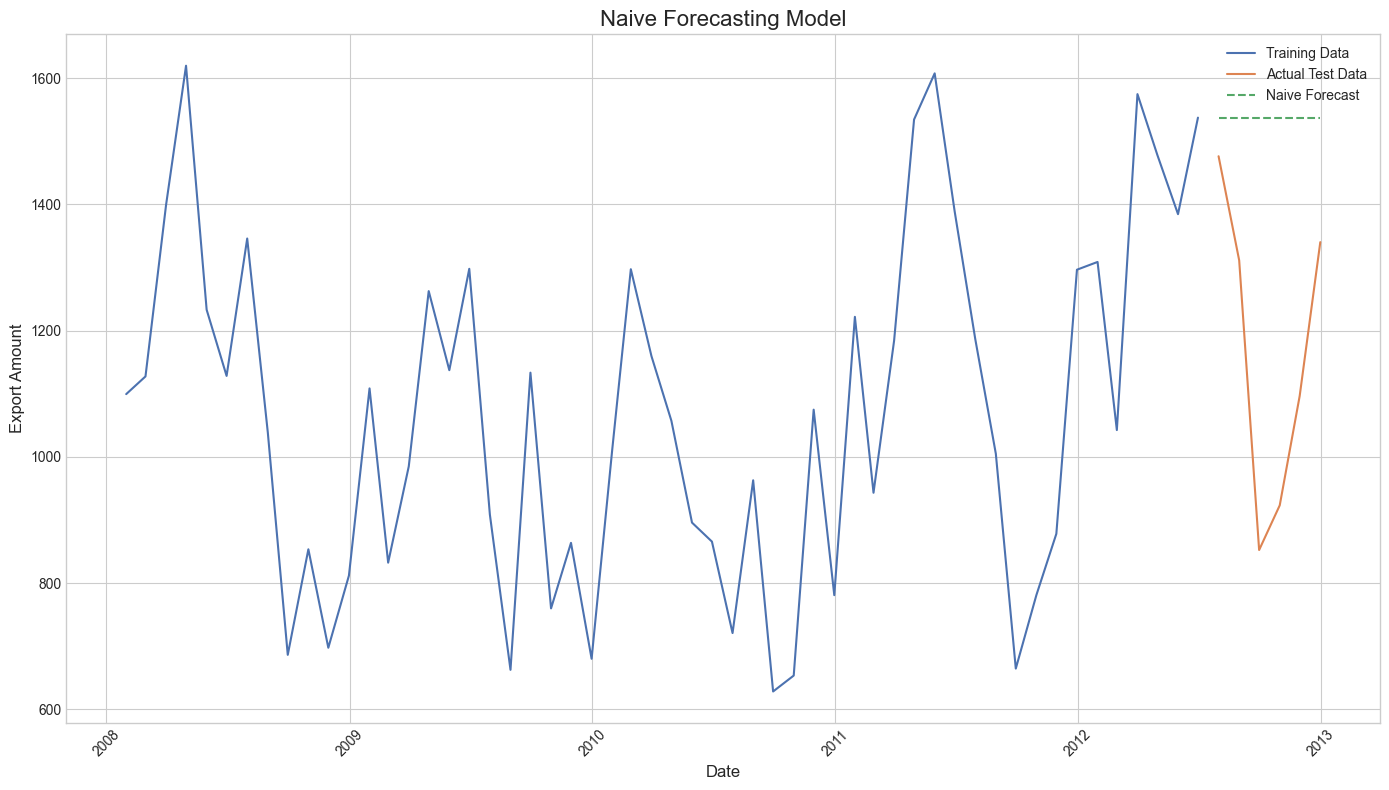

Naive Forecasting Performance Metrics:
Mean Squared Error (MSE): 189092.06
Root Mean Squared Error (RMSE): 434.85
Mean Absolute Error (MAE): 370.75


In [ ]:
# Function to implement naive forecasting and evaluate
def naive_forecast(series, test_size=6):
    # Split data into train and test sets
    train_size = len(series) - test_size
    train, test = series[0:train_size], series[train_size:len(series)]
    
    # Forecast values (naive approach: use the last value of training set)
    naive_predictions = [train.iloc[-1]] * len(test)
    
    # Calculate error metrics
    mse = mean_squared_error(test, naive_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test, naive_predictions)
    
    # Plot actual vs predictions
    plt.figure(figsize=(14, 8))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual Test Data')
    plt.plot(test.index, naive_predictions, label='Naive Forecast', linestyle='--')
    plt.title('Naive Forecasting Model', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Export Amount', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"Naive Forecasting Performance Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    
    return naive_predictions, (mse, rmse, mae)

# Apply naive forecasting
naive_predictions, naive_metrics = naive_forecast(monthly_exports)

### Moving Average

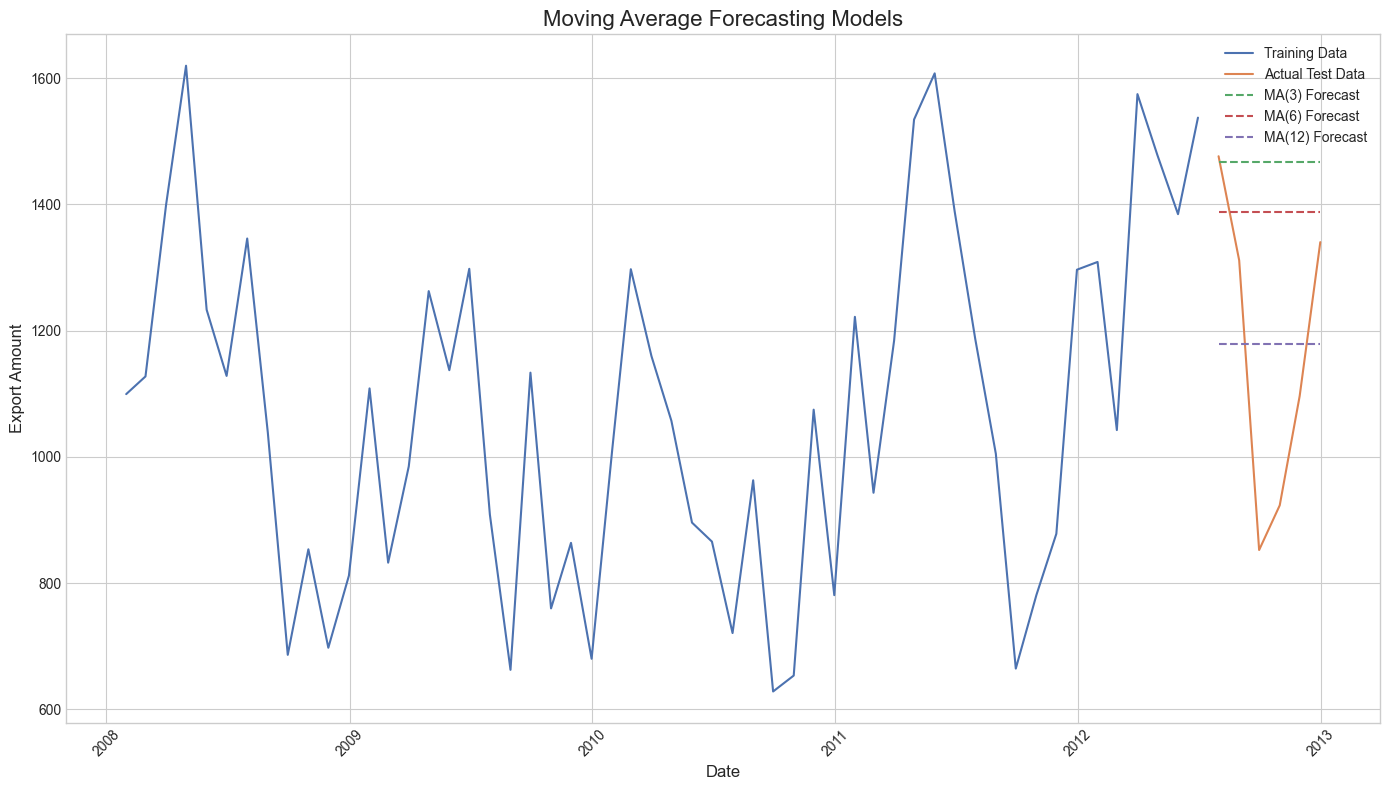

Moving Average Forecasting Performance Metrics:

Window Size = 3
Mean Squared Error (MSE): 141633.86
Root Mean Squared Error (RMSE): 376.34
Mean Absolute Error (MAE): 303.20

Window Size = 6
Mean Squared Error (MSE): 100475.56
Root Mean Squared Error (RMSE): 316.98
Mean Absolute Error (MAE): 250.53

Window Size = 12
Mean Squared Error (MSE): 51769.55
Root Mean Squared Error (RMSE): 227.53
Mean Absolute Error (MAE): 209.27


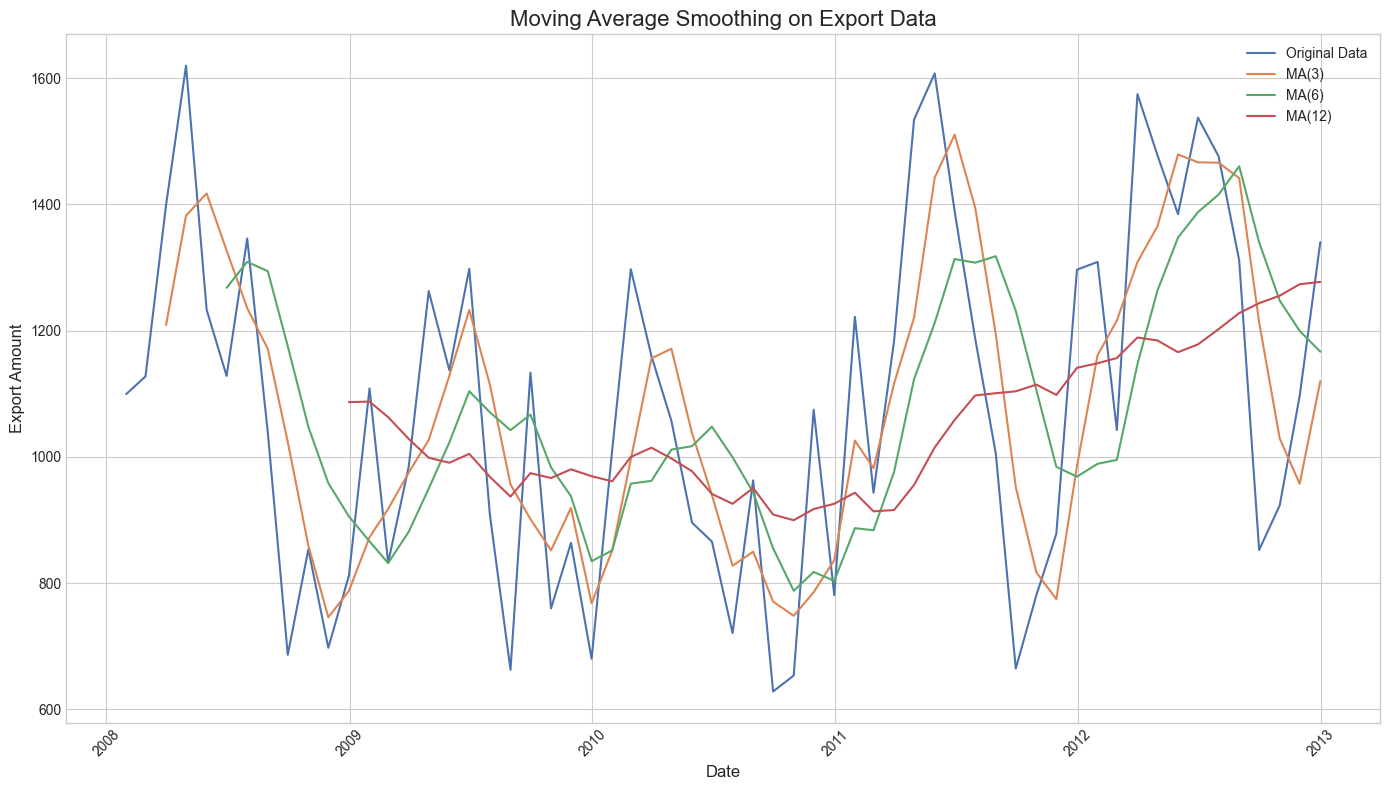

In [ ]:
# Function to implement moving average forecasting
def moving_average_forecast(series, window_sizes=[3, 6, 12], test_size=6):
    # Split data into train and test sets
    train_size = len(series) - test_size
    train, test = series[0:train_size], series[train_size:len(series)]
    
    # Create figure for plotting
    plt.figure(figsize=(14, 8))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual Test Data')
    
    results = {}
    
    for window in window_sizes:
        # Calculate moving average
        ma = train.rolling(window=window).mean()
        
        # Forecast using the last MA value
        ma_forecast = [ma.iloc[-1]] * len(test)
        
        # Calculate error metrics
        mse = mean_squared_error(test, ma_forecast)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test, ma_forecast)
        
        # Store results
        results[window] = {
            'forecast': ma_forecast,
            'mse': mse,
            'rmse': rmse,
            'mae': mae
        }
        
        # Add to plot
        plt.plot(test.index, ma_forecast, label=f'MA({window}) Forecast', linestyle='--')
    
    plt.title('Moving Average Forecasting Models', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Export Amount', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print performance metrics
    print(f"Moving Average Forecasting Performance Metrics:")
    for window in window_sizes:
        print(f"\nWindow Size = {window}")
        print(f"Mean Squared Error (MSE): {results[window]['mse']:.2f}")
        print(f"Root Mean Squared Error (RMSE): {results[window]['rmse']:.2f}")
        print(f"Mean Absolute Error (MAE): {results[window]['mae']:.2f}")
    
    return results

# Apply moving average forecasting
ma_results = moving_average_forecast(monthly_exports)

# Visualize moving averages on the entire dataset
plt.figure(figsize=(14, 8))
plt.plot(monthly_exports.index, monthly_exports, label='Original Data')

for window in [3, 6, 12]:
    ma = monthly_exports.rolling(window=window).mean()
    plt.plot(ma.index, ma, label=f'MA({window})')

plt.title('Moving Average Smoothing on Export Data', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Export Amount', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Exponential Smoothing

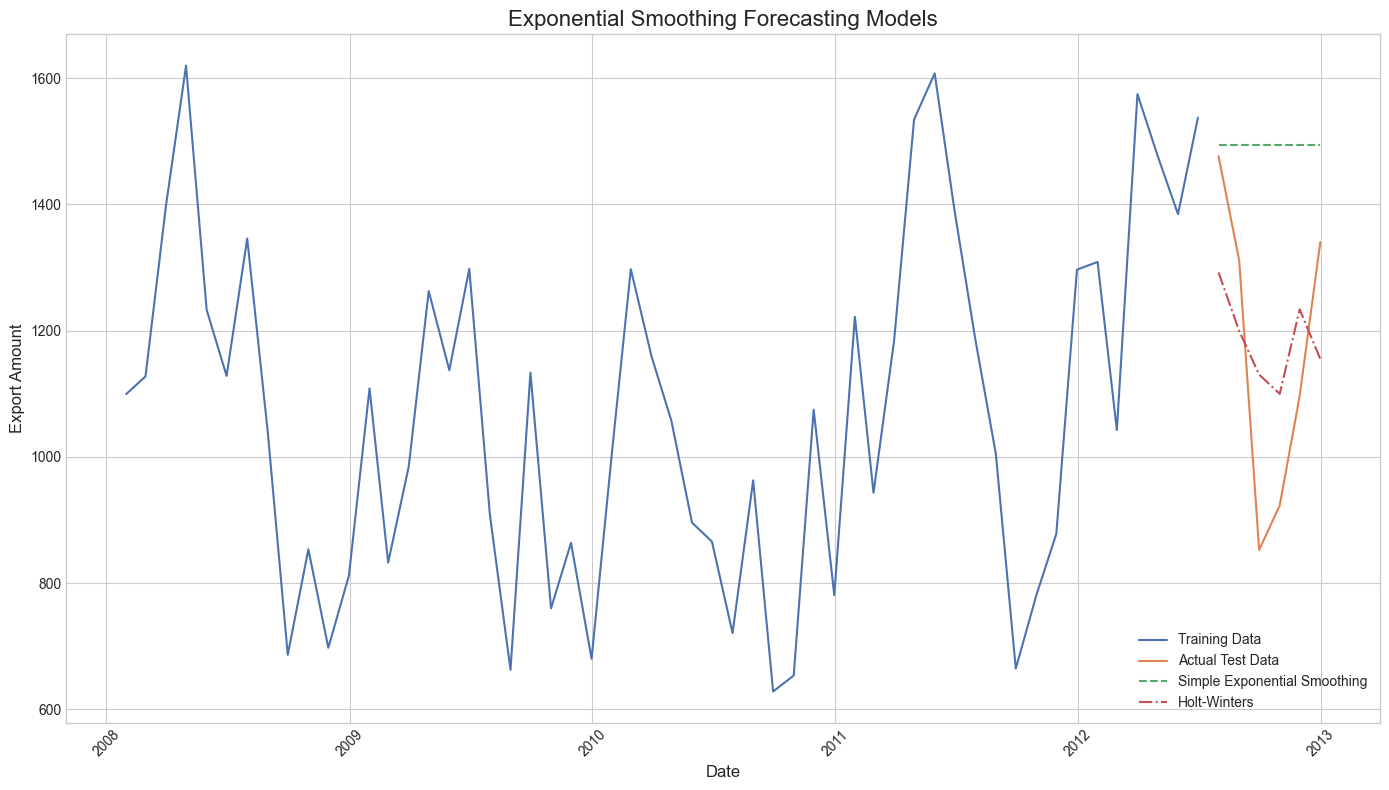

Exponential Smoothing Performance Metrics:

Simple Exponential Smoothing (SES):
Mean Squared Error (MSE): 158838.07
Root Mean Squared Error (RMSE): 398.54
Mean Absolute Error (MAE): 327.42

Holt-Winters Exponential Smoothing:
Mean Squared Error (MSE): 34657.49
Root Mean Squared Error (RMSE): 186.17
Mean Absolute Error (MAE): 178.81


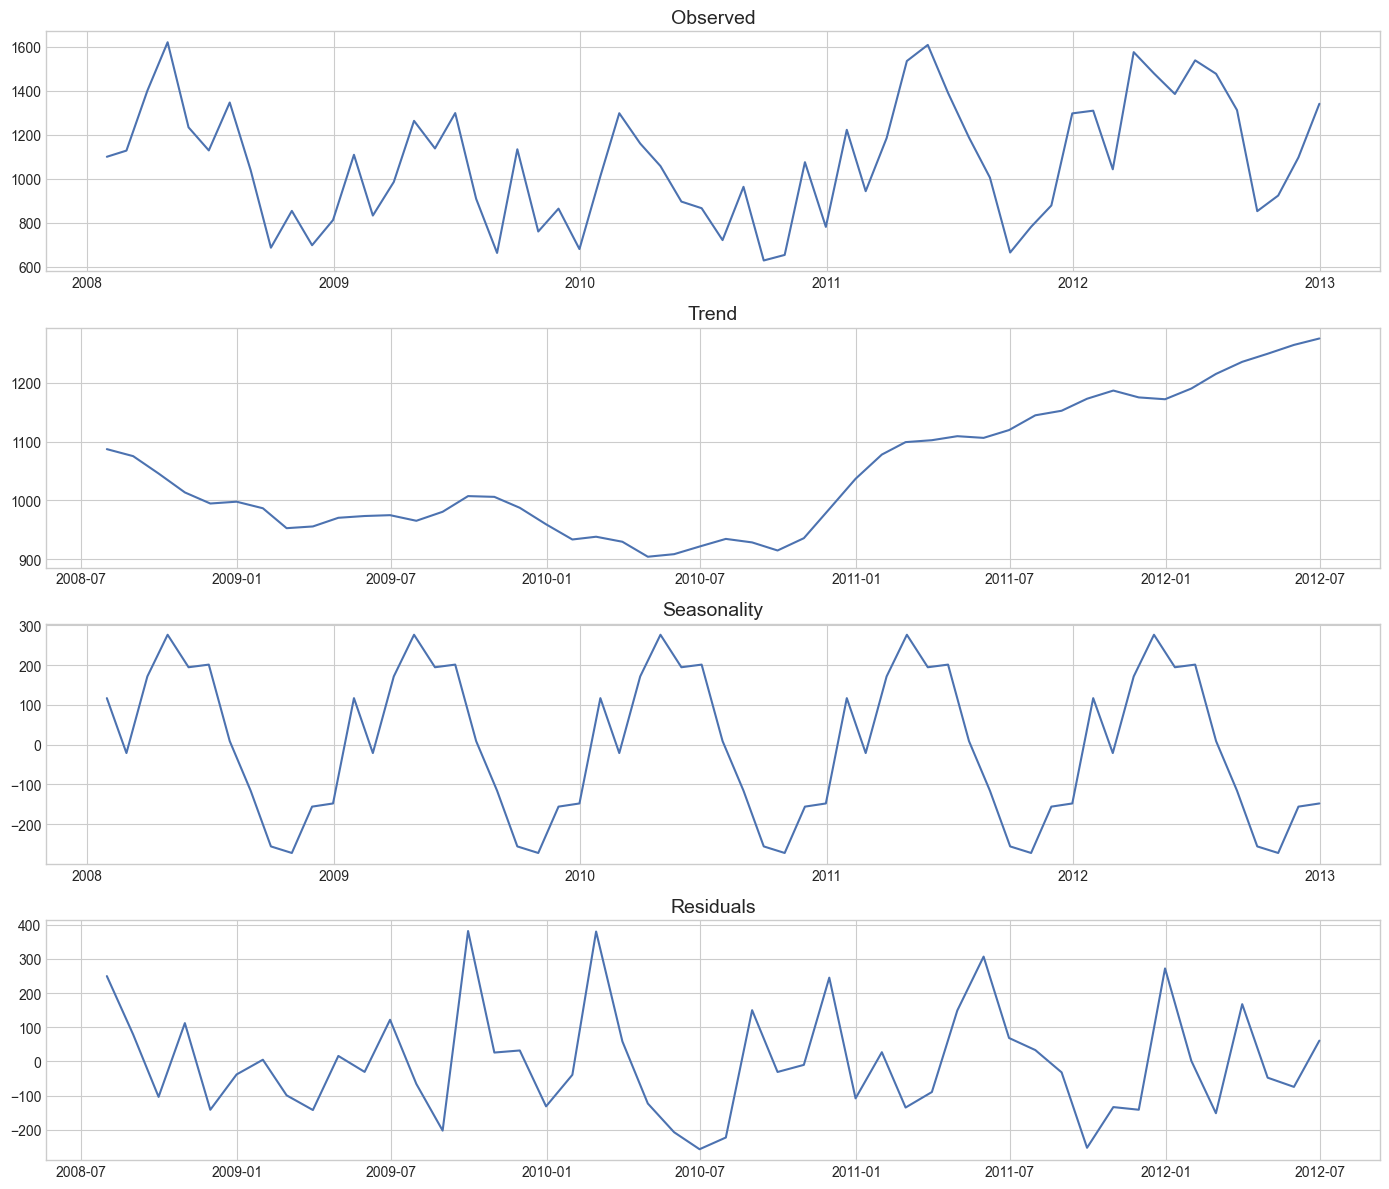

In [ ]:
# Function to implement exponential smoothing
def exponential_smoothing_forecast(series, test_size=6):
    # Split data into train and test sets
    train_size = len(series) - test_size
    train, test = series[0:train_size], series[train_size:len(series)]
    
    # Simple Exponential Smoothing (SES)
    ses_model = ExponentialSmoothing(train, 
                                    trend=None, 
                                    seasonal=None,
                                    initialization_method="estimated")
    ses_fit = ses_model.fit()
    ses_forecast = ses_fit.forecast(test_size)
    
    # Holt's Winter Exponential Smoothing (with trend and seasonality)
    # Assume monthly data with yearly seasonality (period=12)
    hw_model = ExponentialSmoothing(train, 
                                   trend='add', 
                                   seasonal='add', 
                                   seasonal_periods=12,
                                   initialization_method="estimated")
    hw_fit = hw_model.fit()
    hw_forecast = hw_fit.forecast(test_size)
    
    # Create figure for plotting
    plt.figure(figsize=(14, 8))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual Test Data')
    plt.plot(test.index, ses_forecast, label='Simple Exponential Smoothing', linestyle='--')
    plt.plot(test.index, hw_forecast, label='Holt-Winters', linestyle='-.')
    plt.title('Exponential Smoothing Forecasting Models', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Export Amount', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate error metrics for SES
    ses_mse = mean_squared_error(test, ses_forecast)
    ses_rmse = np.sqrt(ses_mse)
    ses_mae = mean_absolute_error(test, ses_forecast)
    
    # Calculate error metrics for Holt-Winters
    hw_mse = mean_squared_error(test, hw_forecast)
    hw_rmse = np.sqrt(hw_mse)
    hw_mae = mean_absolute_error(test, hw_forecast)
    
    # Print performance metrics
    print(f"Exponential Smoothing Performance Metrics:")
    print("\nSimple Exponential Smoothing (SES):")
    print(f"Mean Squared Error (MSE): {ses_mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {ses_rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {ses_mae:.2f}")
    
    print("\nHolt-Winters Exponential Smoothing:")
    print(f"Mean Squared Error (MSE): {hw_mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {hw_rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {hw_mae:.2f}")
    
    results = {
        'SES': {
            'forecast': ses_forecast,
            'mse': ses_mse,
            'rmse': ses_rmse,
            'mae': ses_mae,
            'model': ses_fit
        },
        'Holt-Winters': {
            'forecast': hw_forecast,
            'mse': hw_mse,
            'rmse': hw_rmse,
            'mae': hw_mae,
            'model': hw_fit
        }
    }
    
    return results

# Apply exponential smoothing
exp_smooth_results = exponential_smoothing_forecast(monthly_exports)

# Decompose the time series to see trend, seasonality, and residual components
decomposition = seasonal_decompose(monthly_exports, model='additive', period=12)
plt.figure(figsize=(14, 12))

plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed', fontsize=14)
plt.grid(True)

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend', fontsize=14)
plt.grid(True)

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonality', fontsize=14)
plt.grid(True)

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residuals', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrated various time series analysis techniques for seafood supply chain data, comparing machine learning models for demand forecasting, implementing inventory optimization with EOQ models, and analyzing the impact of the 2010 volcanic eruption on export trends.

Key findings include:
- Time series analysis showed seasonal patterns in seafood exports
- The EOQ model provided insights into optimal inventory management strategies
- The 2010 volcanic eruption significantly impacted seafood exports, with varying effects across different fishing types

These insights can help seafood supply chain stakeholders make more informed decisions about inventory management, demand forecasting, and risk assessment related to natural disasters.